In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from collections import OrderedDict
import cv2
import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import vgg16 as vgg16_model
import vgg16_deconv as vgg16deconv_model

In [2]:
def save(model):
    def hook(module, input, output, key):
        if isinstance(module, nn.MaxPool2d):
            model.feature_maps[key] = output[0]
            model.pool_switch[key] = output[1]
        else:
            model.feature_maps[key] = output
    
    for i, layer in enumerate(model._modules.get('features')):
        layer.register_forward_hook(partial(hook,key=i))

In [3]:
def layerDeconv(layer_idx, conv, deconv):
    print(conv.feature_maps[layer_idx].shape)
    num_fmap = conv.feature_maps[layer_idx].shape[1]
    print(num_fmap)
    copy_fmap = conv.feature_maps[layer_idx].clone()
    
    max_list = []
    for i in range(num_fmap):
        each_fmap = copy_fmap[0,i,:,:]
        max_list.append(torch.max(each_fmap))
    #print(max_list)
    
    max_fnumber = np.argmax(np.array(max_list))
    
    print(copy_fmap[0,max_fnumber,:,:].shape)
    
    # set all feature_map 0 except max_feature_map
    for i in range(max_fnumber):
        copy_fmap[0,i,:,:] = 0
    for i in range(max_fnumber+1,num_fmap):
        copy_fmap[0,i,:,:] = 0
    
    #print(copy_fmap[0,max_fnumber-1,:,:])
    #print(copy_fmap[0,max_fnumber,:,:])
    #print(copy_fmap[0,max_fnumber+1,:,:])
    
    
    # set max_feature_map 0 except maximum value
    max_fmap = copy_fmap[0,max_fnumber,:,:]
    max_val = torch.max(max_fmap)
    
    #print(max_fmap)
    max_fmap = torch.where(max_fmap==max_val, max_fmap, torch.zeros(max_fmap.shape))
    #print(max_fmap)
    
    copy_fmap[0,max_fnumber,:,:] = max_fmap
    
    deconv_output = deconv(copy_fmap, layer_idx, conv.pool_switch)
    print(deconv_output.shape)
    return deconv_output

In [4]:
def visualize(deconv_output):
    #print(deconv_output[0].shape)
    deconv_img = deconv_output[0].data.numpy()
    new_img = np.transpose(deconv_img, (1,2,0))

    new_img = cv2.normalize(new_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    temp = new_img[0,0,0]
    leftx = 244
    lefty = 244
    rightx = 0
    righty = 0
    for i in range(224):
        for j in range(224):
            if new_img[i,j,0] > temp+0.1 or new_img[i,j,0] < temp-0.1:
                leftx = min(i,leftx)
                lefty = min(j,lefty)
                rightx = max(i,rightx)
                righty = max(j,righty)

    print(leftx,lefty, rightx, righty)
    temp = new_img[leftx-5:rightx+5, lefty-5:righty+5, :]

    plt.subplot(1, 2, 1)
    plt.imshow(temp)
    plt.subplot(1, 2, 2)
    plt.imshow(ori_img[leftx-5:rightx+5, lefty-5:righty+5, :])

torch.Size([1, 512, 14, 14])
512
torch.Size([14, 14])
2
torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32 32 136 130


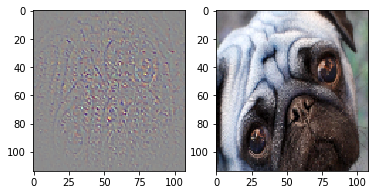

In [5]:
ori_img = cv2.imread('../data/deconv/pug.jpg')
ori_img = cv2.resize(ori_img, (224,224))
#print(ori_img.shape)
#plt.imshow(ori_img)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
img = transform(ori_img)
img = img.unsqueeze_(0)

vgg16 = vgg16_model.VGG16()
save(vgg16)

output = vgg16(img)

vgg16deconv = vgg16deconv_model.VGG16_Deconv()

map_idx = list(vgg16deconv.index_mapping.keys())
print(map_idx)

convLayer_idx = [0,2,5,7,10,12,14,17]

for idx in range(convLayer_idx):
    deconv_output = layerDeconv(idx,vgg16,vgg16deconv)
    visualize(deconv_output)